In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# DL

### Imports

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split
from datetime import datetime
from copy import deepcopy
import torch
from torch.utils.data import Dataset
from torchvision import transforms, models
from torch.utils.data import DataLoader
from torchvision.models import ResNet34_Weights
import torch.nn as nn
from sklearn.metrics import confusion_matrix, accuracy_score

### Loading dataset

In [ ]:
data_folder = '/content/drive/MyDrive/02740/02740 final project /size_1024'
classes_filepaths = {
    0: [],
    1: [],
    2: [],
    3: []
}

for folder in os.listdir(data_folder):
    folder_path = os.path.join(data_folder, folder)
    files = [os.path.join(folder_path, f) for f in os.listdir(folder_path)]
    if 'PD' in folder:
        classes_filepaths[0].extend(files)
    elif 'PR-' in folder:
        classes_filepaths[1].extend(files)
    elif 'CR' in folder:
        classes_filepaths[2].extend(files)
    else:
        classes_filepaths[3].extend(files)

for i in classes_filepaths:
    print(i, len(classes_filepaths[i]))


0 877
1 646
2 747
3 445


In [ ]:
%cd /content/drive/MyDrive/02740/segment-anything
!pip install opencv-python pycocotools matplotlib onnxruntime onnx supervision

In [ ]:
from segment_anything import sam_model_registry
from segment_anything import SamAutomaticMaskGenerator

DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
MODEL_TYPE = "vit_h"
CHECKPOINT_PATH = "sam_vit_h_4b8939.pth"
sam = sam_model_registry[MODEL_TYPE](checkpoint=CHECKPOINT_PATH)
sam.to(device=DEVICE)
mask_generator = SamAutomaticMaskGenerator(sam)

/content/drive/MyDrive/02740/segment-anything/segment_anything/build_sam.py:105: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(f)


In [ ]:
DEVICE

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import cv2
from matplotlib import pyplot as plt
import supervision as sv


class CustomImageDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        """
        Args:
            image_paths (list): List of image file paths.
            labels (list): List of corresponding image labels.
            transform (callable, optional): Optional transform to be applied
                                            on a sample.
        """
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label = self.labels[idx]

        # Open the image
        image_bgr = cv2.imread(img_path)
        image = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)

        # Get segmentation channel
        result = mask_generator.generate(image)
        mask_annotator = sv.MaskAnnotator(color_lookup=sv.ColorLookup.INDEX)
        detections = sv.Detections.from_sam(result)
        annotated_image = mask_annotator.annotate(image_bgr, detections)
        image_gray = cv2.cvtColor(annotated_image, cv2.COLOR_BGR2GRAY)

        # Attach to image
        image = np.dstack((image, image_gray))

        if self.transform:
            image = self.transform(image)

        return image, torch.tensor(label)

def split_dataset(dataset_dict, test_size=0.2, val_size=0.2, random_seed=42):
    """
    Splits the dataset into train, validation, and test sets.

    Args:
        dataset_dict (dict): Dictionary where the keys are categories
                             and the values are lists of filenames.
        test_size (float): Proportion of the dataset to include in the test split.
        val_size (float): Proportion of the dataset to include in the validation split.
        random_seed (int): Random seed for reproducibility.

    Returns:
        train_dataset, val_dataset, test_dataset: PyTorch Datasets for training, validation, and testing.
    """
    # Step 1: Create lists for image paths and labels
    image_paths = []
    labels = []

    for label, filenames in dataset_dict.items():
        for filename in filenames:
            image_paths.append(filename)
            labels.append(label)

    # Step 2: Split data into training + validation and test datasets
    train_val_paths, test_paths, train_val_labels, test_labels = train_test_split(
        image_paths, labels, test_size=test_size, stratify=labels, random_state=random_seed)

    # Step 3: Split the remaining training+validation into train and validation datasets
    val_size_adjusted = val_size / (1 - test_size)  # Adjust for the train + val split
    train_paths, val_paths, train_labels, val_labels = train_test_split(
        train_val_paths, train_val_labels, test_size=val_size_adjusted, stratify=train_val_labels, random_state=random_seed)

    # Step 4: Create PyTorch datasets for each split
    # Define transforms (for example, resizing and normalization)
    transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((1024, 1024)),  # Resize to your desired size
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406, 0.406], std=[0.229, 0.224, 0.225, 0.225]),
    ])

    train_dataset = CustomImageDataset(train_paths, train_labels, transform=transform)
    val_dataset = CustomImageDataset(val_paths, val_labels, transform=transform)
    test_dataset = CustomImageDataset(test_paths, test_labels, transform=transform)

    return train_dataset, val_dataset, test_dataset

In [ ]:
# Split the dataset
train_dataset, val_dataset, test_dataset = split_dataset(classes_filepaths)

# Create DataLoaders for each dataset
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

In [ ]:
for images, labels in train_loader:
    print(images.shape, labels.shape)
    break

torch.Size([16, 4, 1024, 1024]) torch.Size([16])


### Train function, Hyperparameters and Loading ResNet

In [ ]:
# models

model = models.resnet34(weights=ResNet34_Weights.IMAGENET1K_V1)
model.conv1 = nn.Conv2d(4, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)

num_classes = 4
model.fc = nn.Linear(model.fc.in_features, num_classes)

lr = 1e-4
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
num_epochs = 50
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

ResNet(
  (conv1): Conv2d(4, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
from tqdm import tqdm

def train_model(
        num_epochs,
        model,
        criterion,
        device,
        optimizer,
        train_dataloader,
        valid_dataloader,
        curr_best_val_acc=0
):
    timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
    curr_best_val_acc = curr_best_val_acc
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []
    best_model = model

    for epoch in range(num_epochs):
        model.train()
        curr_train_loss = 0.0
        correct_train = 0
        total_train = 0
        for images, labels in tqdm(train_dataloader):
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)

            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            curr_train_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct_train += (preds == labels).sum().item()
            total_train += labels.size(0)

        curr_train_loss /= len(train_dataloader)
        train_losses.append(curr_train_loss)
        train_accuracies.append(correct_train / total_train)

        model.eval()
        curr_val_loss = 0.0
        correct_val = 0
        total_val = 0
        with torch.no_grad():
            for images, labels in tqdm(valid_dataloader):
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)

                curr_val_loss += loss.item()
                _, preds = torch.max(outputs, 1)
                correct_val += (preds == labels).sum().item()
                total_val += labels.size(0)
            curr_val_loss /= len(valid_dataloader)
            val_losses.append(curr_val_loss)
            val_accuracies.append(correct_val / total_val)

        if val_accuracies[-1] > curr_best_val_acc:
            curr_best_val_acc = val_accuracies[-1]
            best_model = deepcopy(model)
            torch.save(model.state_dict(), f'resnet34_{timestamp}_{curr_best_val_acc}.pth')

        print(f"[{epoch+1}]/[{num_epochs}] --- Train loss : {curr_train_loss} --- Val loss : {curr_val_loss}")
        print(f"[{epoch+1}]/[{num_epochs}] --- Train acc : {train_accuracies[-1]} --- Val acc : {val_accuracies[-1]}")

    return best_model, train_losses, val_losses, train_accuracies, val_accuracies

best_model, train_losses, val_losses, train_accuracies, val_accuracies = train_model(
    1,
    model,
    criterion,
    device,
    optimizer,
    train_loader,
    val_loader
)

  8%|▊         | 8/102 [20:54<4:05:45, 156.86s/it]


KeyboardInterrupt: 

### Training

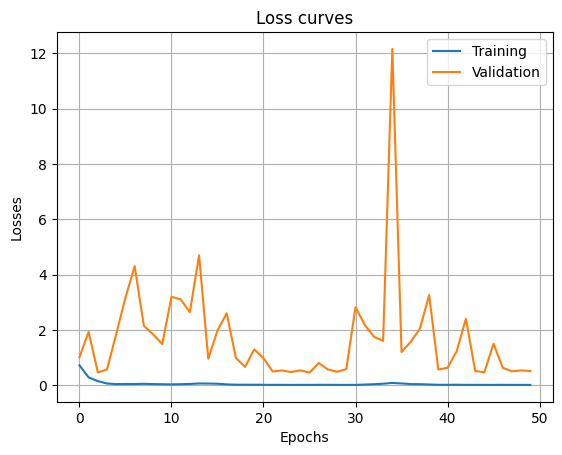

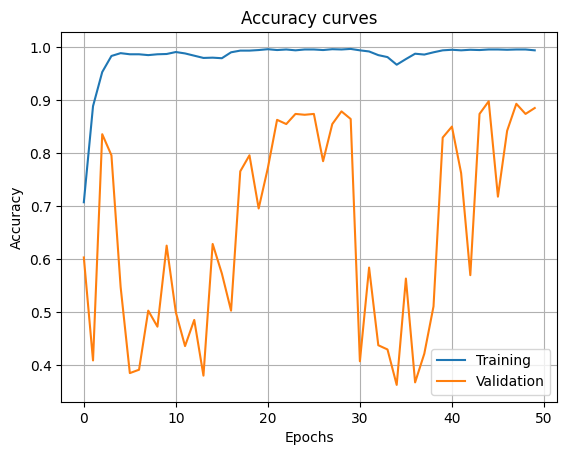

In [ ]:
plt.plot(train_losses, label="Training")
plt.plot(val_losses, label="Validation")
plt.xlabel("Epochs")
plt.ylabel("Losses")
plt.title("Loss curves")
plt.legend()
plt.grid(1)
plt.show()


plt.plot(train_accuracies, label="Training")
plt.plot(val_accuracies, label="Validation")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Accuracy curves")
plt.legend()
plt.grid(1)
plt.show()

In [ ]:
best_model.to(device)
best_model.eval()

all_labels = []
all_preds = []

with torch.no_grad():
    for images, labels in test_dataloader:
        images, labels = images.to(device), labels.to(device)
        outputs = best_model(images)
        _, preds = torch.max(outputs, 1)
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())

accuracy = accuracy_score(all_labels, all_preds)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

conf_matrix = confusion_matrix(all_labels, all_preds)
print("Confusion Matrix:")
print(conf_matrix)

Test Accuracy: 90.11%
Confusion Matrix:
[[126  16   3   1]
 [ 13 125   5   3]
 [  0   5 214   8]
 [  3   2   3 100]]


In [ ]:
classes = ['PD', 'PR', 'CR', 'HLTHY']
class_accuracies = conf_matrix.diagonal() / conf_matrix.sum(axis=1)
for i, class_name in enumerate(classes):
    print(f"Accuracy for class {class_name}: {class_accuracies[i] * 100:.2f}%")

Accuracy for class PD: 87.58%
Accuracy for class PR: 77.27%
Accuracy for class CR: 82.81%
Accuracy for class HLTHY: 66.67%


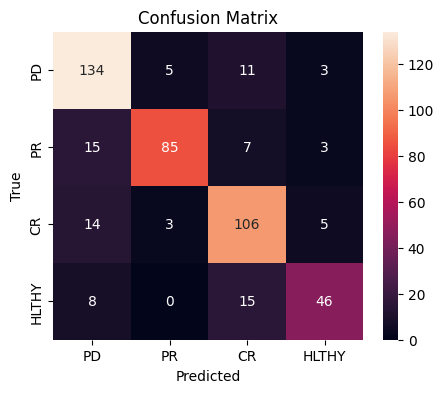

In [ ]:
plt.figure(figsize=(5, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

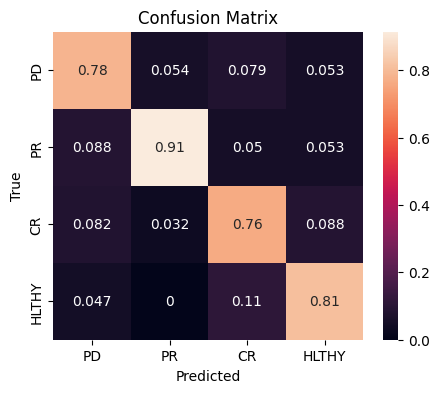

In [ ]:
conf_matrix /= np.sum(conf_matrix, axis=0)
plt.figure(figsize=(5, 4))
sns.heatmap(conf_matrix, annot=True, xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

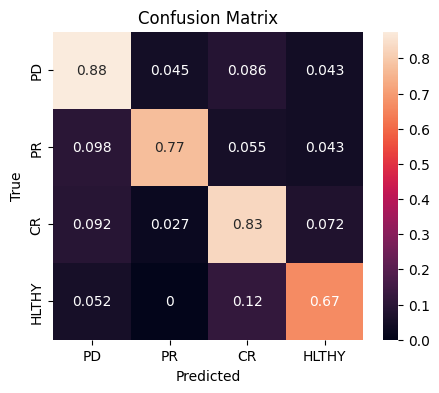

In [ ]:
conf_matrix /= np.sum(conf_matrix, axis=1)
plt.figure(figsize=(5, 4))
sns.heatmap(conf_matrix, annot=True, xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# ML

In [ ]:
data_folder = '/content/drive/MyDrive/02740/02740 final project /Data'

In [ ]:
import os
import cv2
import matplotlib.pyplot as plt

In [ ]:
import numpy as np
import cv2
import os
from skimage.feature import graycomatrix, graycoprops
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler

def extract_geometric_features(mask):
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if not contours:
        return [0, 0, 0, 0]  # No contours, return zeros

    largest_contour = max(contours, key=cv2.contourArea)
    area = cv2.contourArea(largest_contour)
    perimeter = cv2.arcLength(largest_contour, True)
    x, y, w, h = cv2.boundingRect(largest_contour)
    aspect_ratio = w / h if h != 0 else 0
    return [area, perimeter, aspect_ratio]

def extract_numerical_features(mask):
    non_zero_pixels = mask[mask > 0]
    if len(non_zero_pixels) == 0:
        return [0, 0, 0]  # No region, return zeros
    mean_intensity = np.mean(non_zero_pixels)
    std_intensity = np.std(non_zero_pixels)
    sum_intensity = np.sum(non_zero_pixels)
    return [mean_intensity, std_intensity, sum_intensity]

def extract_texture_features(image, mask):
    """Extract texture features using the Gray-Level Co-occurrence Matrix (GLCM)."""
    masked_image = cv2.bitwise_and(image, image, mask=mask)
    gray = cv2.cvtColor(masked_image, cv2.COLOR_BGR2GRAY)
    glcm = graycomatrix(gray, [1], [0, np.pi/4, np.pi/2, 3*np.pi/4], 256, symmetric=True, normed=True)
    contrast = np.mean(graycoprops(glcm, 'contrast'))
    dissimilarity = np.mean(graycoprops(glcm, 'dissimilarity'))
    homogeneity = np.mean(graycoprops(glcm, 'homogeneity'))
    energy = np.mean(graycoprops(glcm, 'energy'))
    correlation = np.mean(graycoprops(glcm, 'correlation'))
    return [contrast, dissimilarity, homogeneity, energy, correlation]

def extract_features_from_dataset(image_dir, mask_dir, labels):
    features = []
    targets = []

    for i, filename in enumerate(image_dir):
        img_path = os.path.join(data_folder, filename)
        mask_path = mask_dir[i]

        image = cv2.imread(img_path)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        if image.shape[:2] != mask.shape:
          mask = mask[:image.shape[0], :image.shape[1]]

        if image is None or mask is None:
            continue

        for i in range(0, image.shape[0], 1024):
          for j in range(0, image.shape[1], 1024):
              patch_image = image[i:min(i + 1024, image.shape[0]), j:min(j + 1024, image.shape[1])]
              patch_mask = mask[i:min(i + 1024, image.shape[0]), j:min(j + 1024, image.shape[1])]

              geo_features = extract_geometric_features(patch_mask)
              num_features = extract_numerical_features(patch_mask)
              tex_features = extract_texture_features(patch_image, patch_mask)

              all_features = geo_features + num_features + tex_features
              features.append(all_features)

              targets.append(labels[filename])

    return np.array(features), np.array(targets)

In [ ]:
filenames = [
    "PD-R1-NA-6-dapi-20a-telC-CERPNB-40x002-MaxIP - Stitched.tif",
    "PR-NA14-R1-dapi-20a-telC-cepnB-40x009-MaxIP - Stitched.tif",
    "R1-CR-NA-12-dapi-20a-telc-cepnB-40x scan004-MaxIP - Stitched.tif",
    "R1-CR-NA-12-dapi-20a-telC-cepnB-40x002-MaxIP - Stitched.tif",
    "Smooth Muscle-NA-2-dapi-20a-telC-CEPRNB-40x-MaxIP - Stitched.tif"
]
masks = [
    "pd_full_mask.png",
    "pr_full_mask.png",
    "cr_1_full_mask.png",
    "cr_2_full_mask.png",
    "hlthy_full_mask.png"
]

In [ ]:
for i in range(5):
    img_path = os.path.join(data_folder, filenames[i])
    mask_path = masks[i]

    image = cv2.imread(img_path)
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

    print(image.shape)
    print(mask.shape)

In [ ]:
image_dir = filenames
mask_dir = masks
labels = {
    "PD-R1-NA-6-dapi-20a-telC-CERPNB-40x002-MaxIP - Stitched.tif": 0,
    "PR-NA14-R1-dapi-20a-telC-cepnB-40x009-MaxIP - Stitched.tif": 1,
    "R1-CR-NA-12-dapi-20a-telc-cepnB-40x scan004-MaxIP - Stitched.tif": 2,
    "R1-CR-NA-12-dapi-20a-telC-cepnB-40x002-MaxIP - Stitched.tif": 2,
    "Smooth Muscle-NA-2-dapi-20a-telC-CEPRNB-40x-MaxIP - Stitched.tif": 3,
}

features, targets = extract_features_from_dataset(image_dir, mask_dir, labels)

In [ ]:
features.shape, targets.shape

((868, 11), (868,))

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(features, targets, test_size=0.4, random_state=42)

classifier = RandomForestClassifier(random_state=42)
classifier.fit(X_train, y_train)

y_pred = classifier.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

Accuracy: 0.86


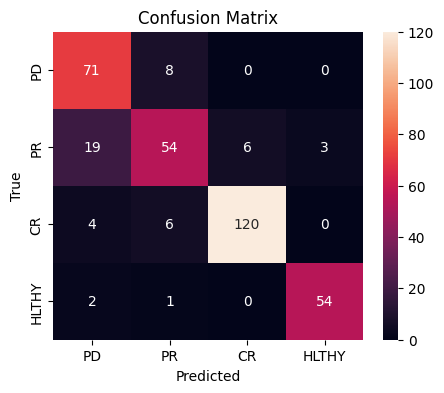

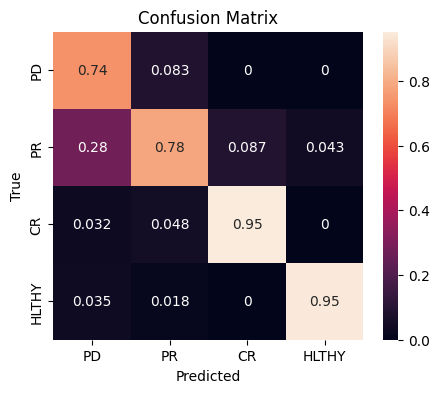

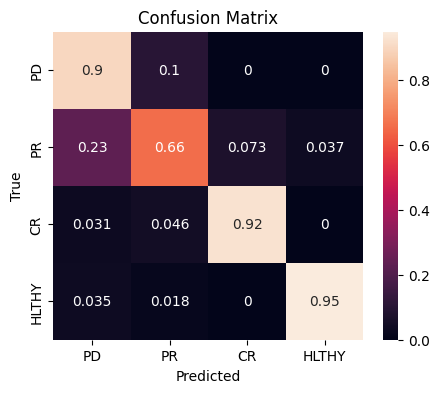

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix


conf_matrix = confusion_matrix(y_test, y_pred)
classes = ['PD', 'PR', 'CR', 'HLTHY']  # Replace with your actual class labels

plt.figure(figsize=(5, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Normalized confusion matrix (by predicted class)
conf_matrix_normalized_pred = conf_matrix.astype('float') / conf_matrix.sum(axis=0)[:, np.newaxis]
plt.figure(figsize=(5, 4))
sns.heatmap(conf_matrix_normalized_pred, annot=True, xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Normalized confusion matrix (by true class)
conf_matrix_normalized_true = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]
plt.figure(figsize=(5, 4))
sns.heatmap(conf_matrix_normalized_true, annot=True, xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()